In [2]:
import math
import os
import gpxpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import streamlit
from scipy.constants import R
from shapely.geometry import Point, LineString
from math import radians
import sl_rtd as sl

#__Author__: pablo-chacon
#__Version__: 1.0.0
#__Date__: 2024-05-11



In [3]:
# Function to parse GPX file and extract waypoint data
def parse_gpx(file_path):
    with open(file_path, 'r') as file:
        gpx = gpxpy.parse(file)
        points_data = []
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    points_data.append({'Latitude': point.latitude, 'Longitude': point.longitude, 'Time': point.time})
        return pd.DataFrame(points_data)


In [4]:
# GPX dir
gpx_dir = 'user_profiles'

# Read GPX files, parse waypoints.
dfs = []
for filename in os.listdir(gpx_dir):
    if filename.endswith('.gpx'):
        gpx_file_path = os.path.join(gpx_dir, filename)
        df = parse_gpx(gpx_file_path)
        dfs.append(df)

# Concatenate DataFrames into DataFrame
gdf = pd.concat(dfs, keys=range(1, len(dfs) + 1))

In [5]:
# Calculate the great circle distance between gps points
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

In [6]:
# Read GPX files and parse waypoints
gpx_folder = 'user_profiles'
user_profiles = []

In [7]:
for filename in os.listdir(gpx_folder):
    if filename.endswith('.gpx'):
        gpx_file_path = os.path.join(gpx_folder, filename)
        df = parse_gpx(gpx_file_path)
        user_profiles.append(df)

# Concatenate DataFrames into one
df = pd.concat(user_profiles, ignore_index=True)

In [8]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [9]:
# Calculate distance and speed
total_distance = 0
for i in range(len(gdf) - 1):
    lat1, lon1 = gdf.iloc[i].Latitude, gdf.iloc[i].Longitude
    lat2, lon2 = gdf.iloc[i + 1].Latitude, gdf.iloc[i + 1].Longitude
    total_distance += haversine_distance(lat1, lon1, lat2, lon2)

gdf['TimeDelta'] = gdf['Time'].diff().dt.total_seconds() / 3600
gdf['Speed'] = total_distance / gdf['TimeDelta']

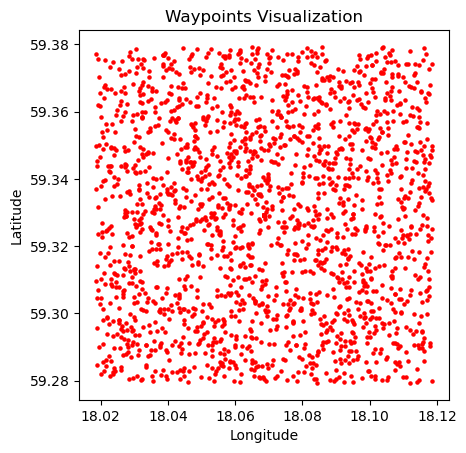

In [10]:
# Plot waypoints
gdf.plot(marker='o', color='red', markersize=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Waypoints Visualization')
plt.show()

In [11]:
pd.to_pickle(gdf, 'trajectory.pkl')

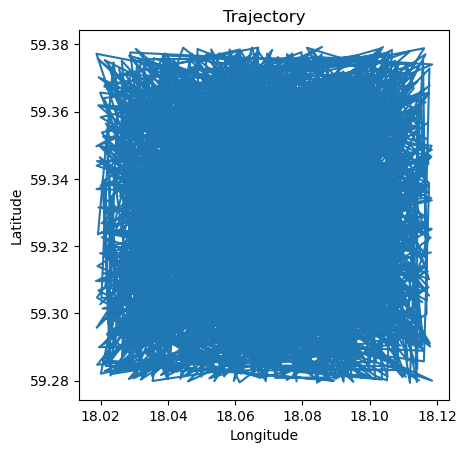

In [12]:
# Plot trajectory
trajectory = LineString(gdf['geometry'])
trajectory_gdf = gpd.GeoDataFrame(geometry=[trajectory])
trajectory_gdf.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectory')
plt.show()

In [67]:
import sl_rtd as sl
import user_trajectories as ut
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# __Author__: pablo-chacon
# __Version__: 1.0.0
# __Date__: 2024-05-23

sl.save_all_data()

Request URL: https://transport.integration.sl.se/v1/lines?transport_authority_id=1
  transport_mode  line_id     line_name designation            group_of_lines  \
0          metro       10    Blå linjen          10    Tunnelbanans blå linje   
1          metro       11    Blå linjen          11    Tunnelbanans blå linje   
2          metro       13   Röda linjen          13   Tunnelbanans röda linje   
3          metro       14   Röda linjen          14   Tunnelbanans röda linje   
4          metro       17  Gröna linjen          17  Tunnelbanans gröna linje   

   transport_authority_id    transport_authority_name  contractor_id  \
0                       1  Storstockholms Lokaltrafik           25.0   
1                       1  Storstockholms Lokaltrafik           25.0   
2                       1  Storstockholms Lokaltrafik           25.0   
3                       1  Storstockholms Lokaltrafik           25.0   
4                       1  Storstockholms Lokaltrafik           25.0  

(    transport_mode  line_id       line_name designation  \
 0            metro       10      Blå linjen          10   
 1            metro       11      Blå linjen          11   
 2            metro       13     Röda linjen          13   
 3            metro       14     Röda linjen          14   
 4            metro       17    Gröna linjen          17   
 ..             ...      ...             ...         ...   
 569           ship       89                          89   
 570           ship      260    Lisen/Lotten         260   
 571           ship      261  Fjäderholmarna         261   
 572          ferry      298                         298   
 573           taxi      299                         299   
 
                group_of_lines  transport_authority_id  \
 0      Tunnelbanans blå linje                       1   
 1      Tunnelbanans blå linje                       1   
 2     Tunnelbanans röda linje                       1   
 3     Tunnelbanans röda linje                

In [61]:
# Load the pickled data
timetable = pd.read_pickle('timetable.pkl')
ut_df = pd.read_pickle('gdf.pkl')
dest_df = pd.read_pickle('dest.pkl')
deviations = pd.read_pickle('deviations.pkl')
nearby_stops = pd.read_pickle('nearby_stops.pkl')




In [62]:
# Print out the data to inspect
print("Timetable DataFrame:")
print(timetable.head())

print("\nUser Trajectories DataFrame:")
print(ut_df.head())

print("\nDestinations DataFrame:")
print(dest_df.head())

print("\nDeviations DataFrame:")
print(deviations_df.head())

print("\nNearby Stops DataFrame:")
print(nearby_stops.head())

Timetable DataFrame:
  transport_mode  line_id     line_name designation            group_of_lines  \
0          metro       10    Blå linjen          10    Tunnelbanans blå linje   
1          metro       11    Blå linjen          11    Tunnelbanans blå linje   
2          metro       13   Röda linjen          13   Tunnelbanans röda linje   
3          metro       14   Röda linjen          14   Tunnelbanans röda linje   
4          metro       17  Gröna linjen          17  Tunnelbanans gröna linje   

   transport_authority_id    transport_authority_name  contractor_id  \
0                       1  Storstockholms Lokaltrafik           25.0   
1                       1  Storstockholms Lokaltrafik           25.0   
2                       1  Storstockholms Lokaltrafik           25.0   
3                       1  Storstockholms Lokaltrafik           25.0   
4                       1  Storstockholms Lokaltrafik           25.0   

  contractor_name           valid_from valid_to  
0        

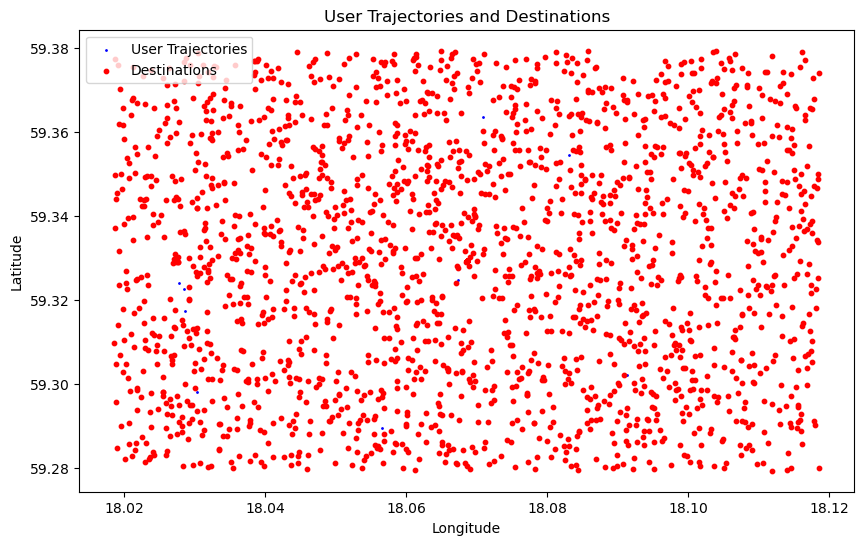

In [63]:
# Plotting the user trajectories
plt.figure(figsize=(10, 6))
plt.scatter(ut_df['Longitude'], ut_df['Latitude'], c='blue', label='User Trajectories', s=1)
plt.scatter(dest_df['Longitude'], dest_df['Latitude'], c='red', label='Destinations', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('User Trajectories and Destinations')
plt.legend()
plt.show()


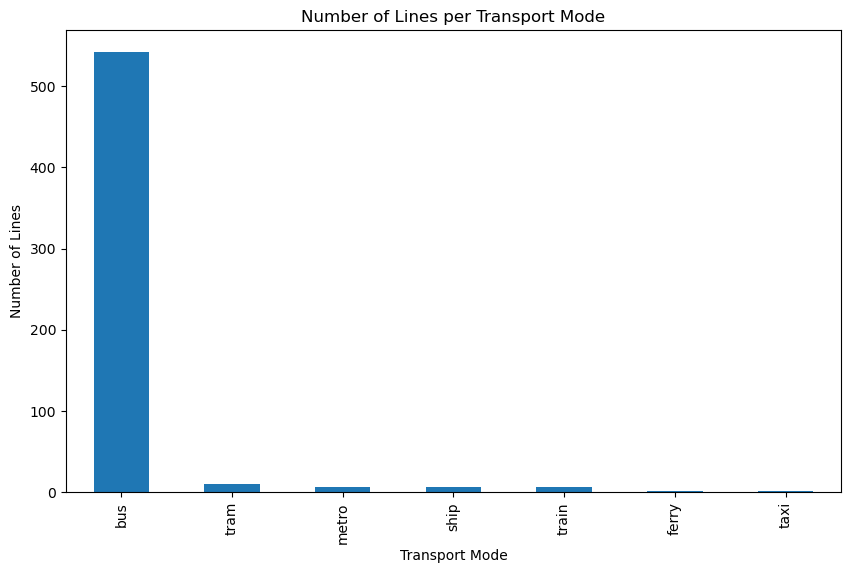

In [64]:
# Plotting the timetable data
plt.figure(figsize=(10, 6))
if 'transport_mode' in timetable_df.columns:
    timetable_modes = timetable_df['transport_mode'].value_counts()
    timetable_modes.plot(kind='bar')
    plt.xlabel('Transport Mode')
    plt.ylabel('Number of Lines')
    plt.title('Number of Lines per Transport Mode')
    plt.show()
else:
    print("The column 'transport_mode' is not present in timetable_df.")

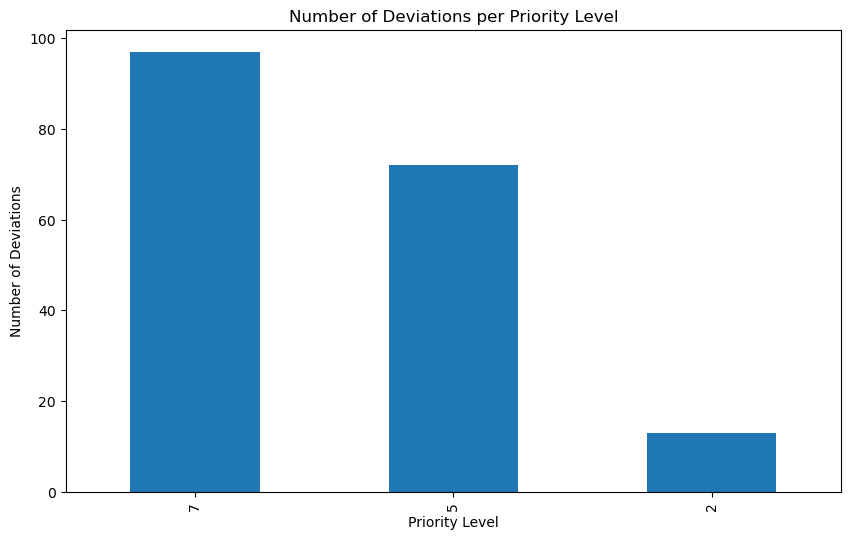

In [65]:
# Plotting the deviations data
plt.figure(figsize=(10, 6))
if 'priority.importance_level' in deviations_df.columns:
    deviations_priority = deviations_df['priority.importance_level'].value_counts()
    deviations_priority.plot(kind='bar')
    plt.xlabel('Priority Level')
    plt.ylabel('Number of Deviations')
    plt.title('Number of Deviations per Priority Level')
    plt.show()
else:
    print("The column 'priority.importance_level' is not present in deviations_df.")

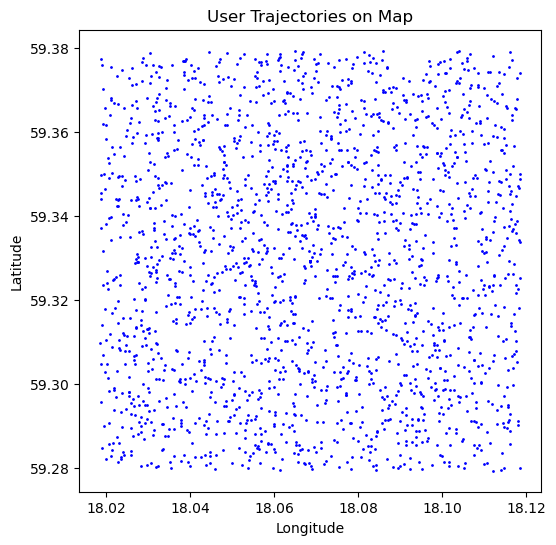

In [66]:
# Convert user trajectories DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(ut_df, geometry=gpd.points_from_xy(ut_df.Longitude, ut_df.Latitude))

# Plotting the trajectories on a map
gdf.plot(marker='o', color='blue', markersize=1, figsize=(10, 6))
plt.title('User Trajectories on Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()